# ComplEx on WN18 and FB15K

This notebook reproduces the experiments done in the paper that introduced the ComplEx algorith: Complex Embeddings for Simple Link Prediction, Théo Trouillon, Johannes Welbl, Sebastian Riedel, Éric Gaussier and Guillaume Bouchard, ICML 2016. http://jmlr.org/proceedings/papers/v48/trouillon16.pdf

In table 4, the paper reports five metrics measured on the WN18 and FB15K datasets: "raw" MRR (mean reciprocal rank), "filtered" MRR and filtered Hits at {1, 3, 10}.

|dataset|raw MRR|filtered MRR|hits at 1|hits at 3|hits at 10|
|---|---|---|---|---|---|
|WN18|0.587|0.941|0.936|0.945|0.947|
|FB15K|0.242|0.692|0.599|0.759|0.850|

This notebook measures all of these (and the "raw" Hits at {1, 3, 10} too).

In [6]:
from stellargraph import datasets
from tensorflow.keras import layers, optimizers, losses, metrics, regularizers, Model, utils
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx

import timeit
from IPython.display import Markdown

## Initialisation

We need to set up our model parameters, like the number of epochs to train for, and the dimension of the embedding vectors we compute for each node and for each edge type. We'll also define a function to do our evaluation, so we can easily apply it to both WN18 and FB15k.

The evaluation is performed in four main steps:

1. **load the data into a graph**: the `WN18` and `FB15k` dataset loaders from `stellargraph.datasets` automatically download and parse the dataset, so the code for this is compact and efficient. This includes reading the pre-defined train, test and validation sets specified within the dataset.
2. **create the `ComplEx` model**: the model consists of some embedding layers and a scoring layer, but the `ComplEx` object means these details are invisible to us. The `ComplEx` model consumes "knowledge-graph triples", which can be produced in the appropriate format using `KGTripleGenerator`.
3. **train the model using the train and validation sets**: inputs for training are produced by calling the `KGTripleGenerator.flow` method, this takes a dataframe with `source`, `label` and `target` columns, where each row is a true edge in the knowledge graph. The `negative_samples` parameter controls how many random edges are created for each positive edge to use as negative examples for training.
4. **calculate the edge rankings on the test set**: the algorithms are evaluated by taking each test edge `E = (s, r, o)`, and scoring it against all mutations `(s, r, n)` and `(n, r, o)` for every node `n` in the graph, that is, doing a prediction for every one of these edges similar to `E`. The "raw" rank is the number of mutated edges that have a higher predicted score than the true `E`, and the "filtered" rank is the number of mutated edges that aren't known (aren't in the train, test or validation datasets) that have a higher predicted score than `E`. The `ComplEx.rank_edges_against_all_nodes` packages up this computation in a way that is very much more efficient than calling `model.predict` manually, and returns the raw and filtered ranks for each edge in the test set.

The paper describes using the AdaGrad optimiser for 1000 epochs with an early stopping criterion evaluated every 50 epochs. We've found using the Adam optimiser allows for much fewer epochs. The paper says that the best choices of embedding dimension are generally 150 or 200, with close results. The paper evaluated using 1, 2, 5 and 10 negative samples, and found that using 10 improved performance on FB15k noticably (comparing to 1), but did not make much difference on WN18.

In [34]:
epochs = 20
embedding_dimension = 200
negative_samples = 10

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

In [36]:
def summarise(ranks):
    return {"mrr": np.mean(1 / ranks), "hits at 1": np.mean(ranks <= 1), "hits at 3": np.mean(ranks <= 3), "hits at 10": np.mean(ranks <= 10)}
    
def run_evaluation(dataset):
    display(Markdown("### 1. Loading data"))
    start = timeit.default_timer()
    g, (train, test, valid) = dataset.load()
    end = timeit.default_timer()
    display(Markdown(f"Loading took {end - start:.1f} seconds."))
    
    display(Markdown("### 2. Creating model"))
    gen = KGTripleGenerator(g, batch_size=len(train)//100) # ~100 batches per epoch
    complex_model = ComplEx(gen, k=embedding_dimension)
    
    x_inp, x_out = complex_model.build()
    
    model = Model(inputs=x_inp, outputs=x_out)
    model.compile(
        optimizer=optimizers.Adam(lr=0.01),
        loss=losses.BinaryCrossentropy(from_logits=True),
        metrics=[metrics.BinaryAccuracy(threshold=0.)],
    )
    
    display(Markdown("### 3. Training"))
    history = model.fit(
        gen.flow(train, negative_samples=negative_samples, shuffle=True), 
        validation_data=gen.flow(valid, negative_samples=negative_samples), 
        epochs=epochs
    )
    
    # show how the metrics evolve for each epoch
    plot_history(history)
    
    display(Markdown("### 4. Ranking"))
    
    start = timeit.default_timer()
    raw, filtered = ComplEx.rank_edges_against_all_nodes(model, gen.flow(test), g)
    end = timeit.default_timer()
    
    display(Markdown(f"Ranking took {end - start:.1f} seconds."))
    
    return pd.DataFrame([summarise(raw), summarise(filtered)], index=["raw", "filtered"])

## Evaluation

### 1. Loading data

Loading took 0.7 seconds.

### 2. Creating model

### 3. Training

Train for 101 steps, validate for 4 steps
Epoch 1/20
101/101 [==============================] - 27s 270ms/step - loss: 0.6930 - binary_accuracy: 0.5098 - val_loss: 0.6918 - val_binary_accuracy: 0.5410
Epoch 2/20
101/101 [==============================] - 26s 256ms/step - loss: 0.4313 - binary_accuracy: 0.8393 - val_loss: 0.1589 - val_binary_accuracy: 0.9564
Epoch 3/20
101/101 [==============================] - 27s 264ms/step - loss: 0.0524 - binary_accuracy: 0.9882 - val_loss: 0.0484 - val_binary_accuracy: 0.9920
Epoch 4/20
101/101 [==============================] - 26s 260ms/step - loss: 0.0116 - binary_accuracy: 0.9988 - val_loss: 0.0428 - val_binary_accuracy: 0.9938
Epoch 5/20
101/101 [==============================] - 27s 272ms/step - loss: 0.0086 - binary_accuracy: 0.9990 - val_loss: 0.0462 - val_binary_accuracy: 0.9939
Epoch 6/20
101/101 [==============================] - 28s 277ms/step - loss: 0.0079 - binary_accuracy: 0.9990 - val_loss: 0.0470 - val_binary_accuracy: 0.9938
Epoc

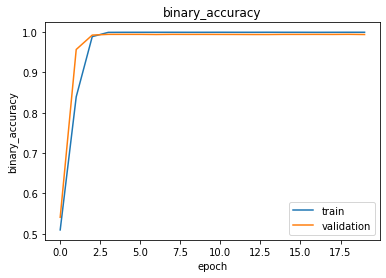

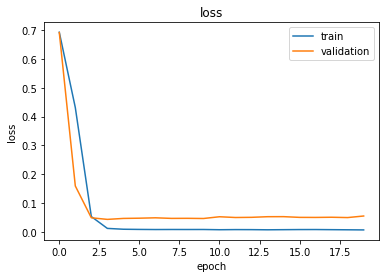

### 4. Ranking

Ranking took 6.4 seconds.

In [37]:
wn18 = run_evaluation(datasets.WN18())

### Loading data

Loading took 5.0 seconds.

### Creating model

### Training

Train for 101 steps, validate for 11 steps
Epoch 1/10
101/101 [==============================] - 2s 24ms/step - loss: 0.6926 - binary_accuracy: 0.5376 - val_loss: 0.6807 - val_binary_accuracy: 0.8644
Epoch 2/10
101/101 [==============================] - 2s 16ms/step - loss: 0.3547 - binary_accuracy: 0.9080 - val_loss: 0.2155 - val_binary_accuracy: 0.9181
Epoch 3/10
101/101 [==============================] - 2s 16ms/step - loss: 0.1698 - binary_accuracy: 0.9291 - val_loss: 0.1449 - val_binary_accuracy: 0.9360
Epoch 4/10
101/101 [==============================] - 2s 16ms/step - loss: 0.1321 - binary_accuracy: 0.9405 - val_loss: 0.1272 - val_binary_accuracy: 0.9421
Epoch 5/10
101/101 [==============================] - 2s 16ms/step - loss: 0.1189 - binary_accuracy: 0.9453 - val_loss: 0.1183 - val_binary_accuracy: 0.9457
Epoch 6/10
101/101 [==============================] - 2s 17ms/step - loss: 0.1118 - binary_accuracy: 0.9483 - val_loss: 0.1136 - val_binary_accuracy: 0.9478
Epoch 7/10
101/

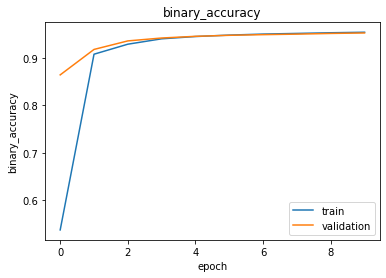

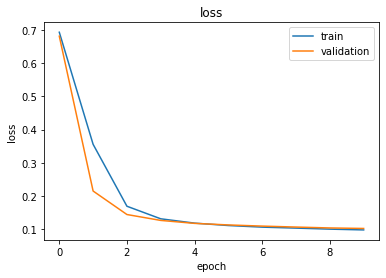

### Ranking

Ranking took 44.7 seconds.

In [28]:
fb15k = run_evaluation(datasets.FB15k())

## Results

The raw MRR numbers are similar to the reported numbers in the paper, but the filtered metrics are very different.

In [29]:
wn18.style

,mrr,hits at 1,hits at 3,hits at 10
raw,0.0508992,0.0261,0.0498,0.0912
filtered,0.0509566,0.0261,0.0498,0.0912


In [30]:
fb15k.style

,mrr,hits at 1,hits at 3,hits at 10
raw,0.0816308,0.0312336,0.0769244,0.179716
filtered,0.0998631,0.0503801,0.0948266,0.19755
